In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne #the main neuroscience library that knows how to work with eeg files, flitering, event markers, etc.
from mne.datasets import eegbci
from mne.io import read_raw_edf # edf is a common eeg file format 
from mne.channels import make_standard_montage

import networkx as nx

In [2]:
# Experiment choice
SUBJECT = 1

#EEGMMIDB run numbers:
#1 = baseline (eyes are open)
#3 = motor execution (left vs. right fist)
RUN_REST = 1
RUN_TASK = 3

In [3]:
# Download the EDF files and return local file paths
rest_files = eegbci.load_data(subjects=SUBJECT, runs=RUN_REST)
task_files = eegbci.load_data(subjects=SUBJECT, runs=RUN_TASK)

rest_files, task_files

Using default location ~/mne_data for EEGBCI...
Creating C:\Users\shayn\mne_data


Do you want to set the path:
    C:\Users\shayn\mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n?  y


Attempting to create new mne-python configuration file:
C:\Users\shayn\.mne\mne-python.json
Could not read the C:\Users\shayn\.mne\mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 01m35s (1.2 MB)


Download complete in 05s (2.5 MB)


([WindowsPath('C:/Users/shayn/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf')],
 [WindowsPath('C:/Users/shayn/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf')])

In [4]:
raw_rest = read_raw_edf(rest_files[0], preload = True, verbose = False)
raw_task = read_raw_edf(task_files[0], preload = True, verbose = False)

raw_rest, raw_task

(<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~4.8 MiB, data loaded>,
 <RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>)

In [12]:
from mne.channels import make_standard_montage

montage = make_standard_montage("standard_1020")

def clean_ch_name(name:str) -> str:
    #remove trailing dots and make uppercase in order to properly sanitize channel names before setting montage
    return name.replace(".", "").upper()
    
for raw in [raw_rest, raw_task]:
    #edf file might contain non-eeg channels
    #ensure that only channels labeled eeg stay
    raw.pick(picks = "eeg")

    #create a dictionary to maps the old name to the new name since rename_channels() expects a dictionary
    mapping = {ch: clean_ch_name(ch) for ch in raw.ch_names}
    
    #rename channels to match standard montage naming
    raw.rename_channels(mapping)

    #attachs the montage (electrode position information) to the eeg recording
    raw.set_montage(montage, match_case=False)


In [14]:
#make copies to ensure raw data isn't overwritten
raw_rest_alpha = raw_rest.copy()
raw_task_alpha = raw_task.copy()

#band-pass filter to alpha(8-13 Hz)
raw_rest_alpha.filter(l_freq=8, h_freq=13)
raw_task_alpha.filter(l_freq=8, h_freq=13)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 265 samples (1.656 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13

<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [16]:
#split the filtered eeg into short time windows called epochs
EPOCH_LEN = 2.0  # seconds
OVERLAP = 1.0    # seconds (50% overlap)

def make_fixed_length_epochs(raw, duration=2.0, overlap=1.0):
    return mne.make_fixed_length_epochs(
        raw,
        duration = duration,
        overlap = overlap,
        preload = True,
        verbose = False

    )

epochs_rest = make_fixed_length_epochs(raw_rest_alpha, duration=EPOCH_LEN, overlap=OVERLAP)
epochs_task = make_fixed_length_epochs(raw_task_alpha, duration=EPOCH_LEN, overlap=OVERLAP)

print("Rest epochs", len(epochs_rest))
print("Task epochs", len(epochs_task))
print("Epoch shape (n_epochs, n_channels, n_times):", epochs_rest.get_data().shape)

Rest epochs 60
Task epochs 124
Epoch shape (n_epochs, n_channels, n_times): (60, 64, 320)


In [17]:
#compute coherence connectivity for each condition
from mne_connectivity import spectral_connectivity_epochs

#alpha band
FMIN, FMAX = 8.0, 13.0

def coherence_matrix (epochs, fmin=8.0, fmax=13.0):
    con = spectral_connectivity_epochs(
        epochs,
        method = "coh", #coherence
        mode = "fourier", #frequency-domain method
        fmin = fmin,
        fmax = fmax,
        faverage = True, 
        verbose = False
    )
    #get dense (n_channels x n_channels) matrix
    return con.get_data(output = "dense")[:, :, 0]

C_rest = coherence_matrix(epochs_rest, FMIN, FMAX)
C_task = coherence_matrix(epochs_task, FMIN, FMAX)

print("Connectivity matrix shape:", C_rest.shape, C_task.shape)
print("Rest coherence range:", float(C_rest.min()), "to", float(C_rest.max()))
print("Task coherence range:", float(C_task.min()), "to", float(C_task.max()))

Connectivity matrix shape: (64, 64) (64, 64)
Rest coherence range: 0.0 to 0.9991216106670094
Task coherence range: 0.0 to 0.9992027249142034


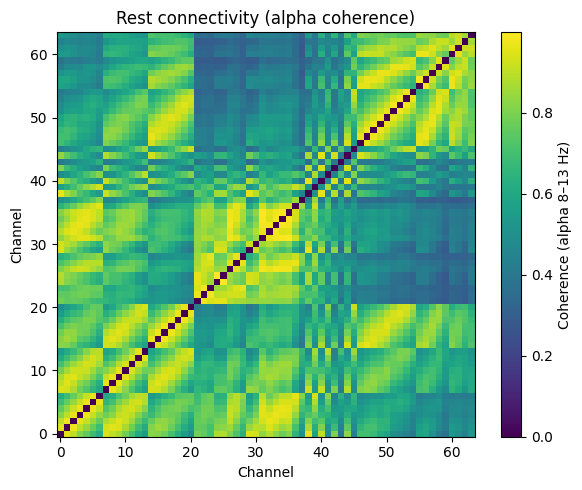

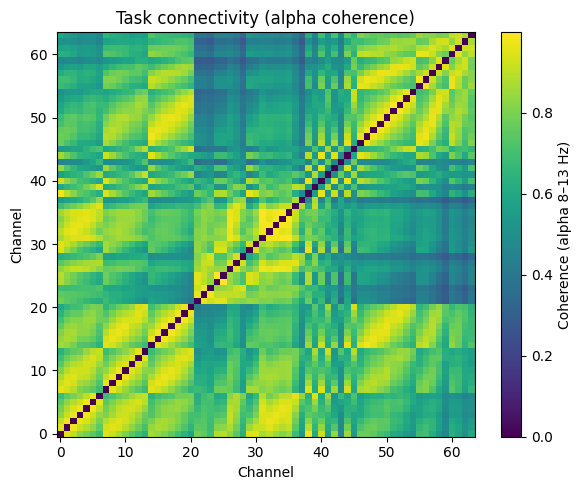

In [42]:
def plot_conn_save(mat, title, outfile):
    plt.figure(figsize=(6, 5))
    plt.imshow(mat, aspect="auto", origin="lower")
    plt.colorbar(label="Coherence (alpha 8–13 Hz)")
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Channel")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.show()

plot_conn_save(C_rest_sym, "Rest connectivity (alpha coherence)", "figures/rest_connectivity.png")
plot_conn_save(C_task_sym, "Task connectivity (alpha coherence)", "figures/task_connectivity.png")


In [36]:
def symmetrize(C):
    C = np.asarray(C).copy()
    np.fill_diagonal(C, 0.0)
    return C + C.T

C_rest_sym = symmetrize(C_rest)
C_task_sym = symmetrize(C_task)

# quick proof it worked: upper triangle should now have nonzeros
n = C_rest_sym.shape[0]
iu = np.triu_indices(n, k=1)
print("Upper-triangle nonzeros (rest):", int(np.sum(C_rest_sym[iu] > 0)))
print("Upper-triangle nonzeros (task):", int(np.sum(C_task_sym[iu] > 0)))
print("Sym rest min/max:", float(C_rest_sym.min()), float(C_rest_sym.max()))
print("Sym task min/max:", float(C_task_sym.min()), float(C_task_sym.max()))


Upper-triangle nonzeros (rest): 2016
Upper-triangle nonzeros (task): 2016
Sym rest min/max: 0.0 0.9991216106670094
Sym task min/max: 0.0 0.9992027249142034


In [37]:
def matrix_to_graph_topk(C, ch_names, top_k=200):
    C = np.asarray(C).copy()
    np.fill_diagonal(C, 0.0)

    n = C.shape[0]
    iu = np.triu_indices(n, k=1)
    weights = np.nan_to_num(C[iu], nan=0.0)

    # Keep only positive weights
    pos = np.where(weights > 0)[0]
    if len(pos) == 0:
        raise ValueError("No positive weights found. Did you use the symmetrized matrix?")

    k = min(top_k, len(pos))
    wpos = weights[pos]

    # pick top-k among positive weights
    top_local = np.argpartition(wpos, -k)[-k:]
    top_local = top_local[np.argsort(wpos[top_local])[::-1]]
    top_idx = pos[top_local]

    G = nx.Graph()
    G.add_nodes_from(ch_names)

    for idx in top_idx:
        i = iu[0][idx]
        j = iu[1][idx]
        w = float(weights[idx])
        G.add_edge(ch_names[i], ch_names[j], weight=w)

    cutoff = float(weights[top_idx[-1]])
    return G, cutoff, k

ch_names = raw_rest_alpha.ch_names

G_rest, cutoff_rest, k_rest = matrix_to_graph_topk(C_rest_sym, ch_names, top_k=200)
G_task, cutoff_task, k_task = matrix_to_graph_topk(C_task_sym, ch_names, top_k=200)

print("Rest edges kept:", k_rest, "cutoff:", cutoff_rest)
print("Task edges kept:", k_task, "cutoff:", cutoff_task)
print("Rest graph:", G_rest.number_of_nodes(), "nodes,", G_rest.number_of_edges(), "edges")
print("Task graph:", G_task.number_of_nodes(), "nodes,", G_task.number_of_edges(), "edges")


Rest edges kept: 200 cutoff: 0.9074964590703847
Task edges kept: 200 cutoff: 0.9147431771183054
Rest graph: 64 nodes, 200 edges
Task graph: 64 nodes, 200 edges


In [38]:
def graph_metrics(G):
    # Degree = number of edges connected to each node
    degrees = np.array([d for _, d in G.degree()])

    # Weighted clustering can be sensitive; normalize weights first to be safe
    edge_weights = [data.get("weight", 0.0) for _, _, data in G.edges(data=True)]
    max_w = max(edge_weights) if edge_weights else 0.0

    if max_w <= 0:
        clustering_vals = np.array(list(nx.clustering(G, weight=None).values()))
    else:
        H = G.copy()
        for u, v, data in H.edges(data=True):
            data["w_norm"] = data.get("weight", 0.0) / max_w
        clustering_vals = np.array(list(nx.clustering(H, weight="w_norm").values()))

    return {
        "mean_degree": float(degrees.mean()),
        "mean_clustering": float(clustering_vals.mean()),
        "median_degree": float(np.median(degrees)),
        "median_clustering": float(np.median(clustering_vals)),
        "edges": int(G.number_of_edges()),
    }

metrics_rest = graph_metrics(G_rest)
metrics_task = graph_metrics(G_task)

print("Rest metrics:", metrics_rest)
print("Task metrics:", metrics_task)


Rest metrics: {'mean_degree': 6.25, 'mean_clustering': 0.4770705144307291, 'median_degree': 6.5, 'median_clustering': 0.4722963962901922, 'edges': 200}
Task metrics: {'mean_degree': 6.25, 'mean_clustering': 0.45221984400286735, 'median_degree': 7.0, 'median_clustering': 0.4514805689012864, 'edges': 200}


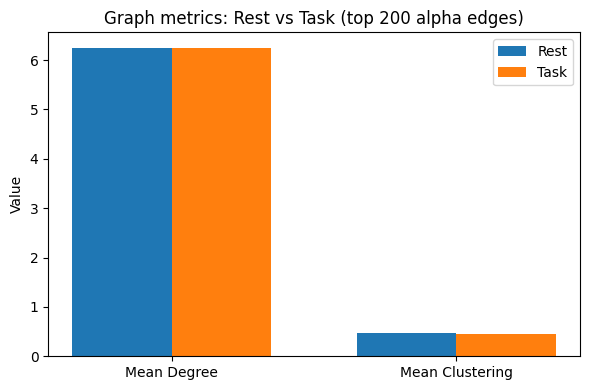

In [39]:
labels = ["Mean Degree", "Mean Clustering"]
rest_vals = [metrics_rest["mean_degree"], metrics_rest["mean_clustering"]]
task_vals = [metrics_task["mean_degree"], metrics_task["mean_clustering"]]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, rest_vals, width, label="Rest")
plt.bar(x + width/2, task_vals, width, label="Task")
plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Graph metrics: Rest vs Task (top 200 alpha edges)")
plt.legend()
plt.tight_layout()

plt.savefig("figures/metrics_compare.png", dpi=200)
plt.show()


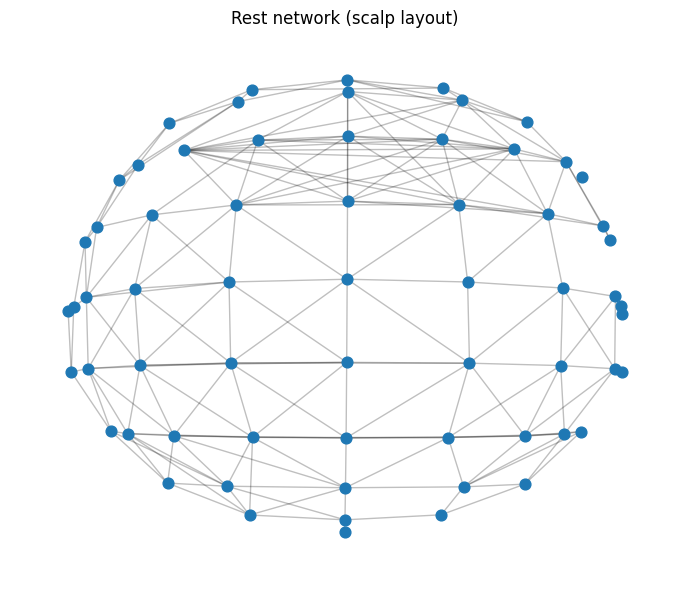

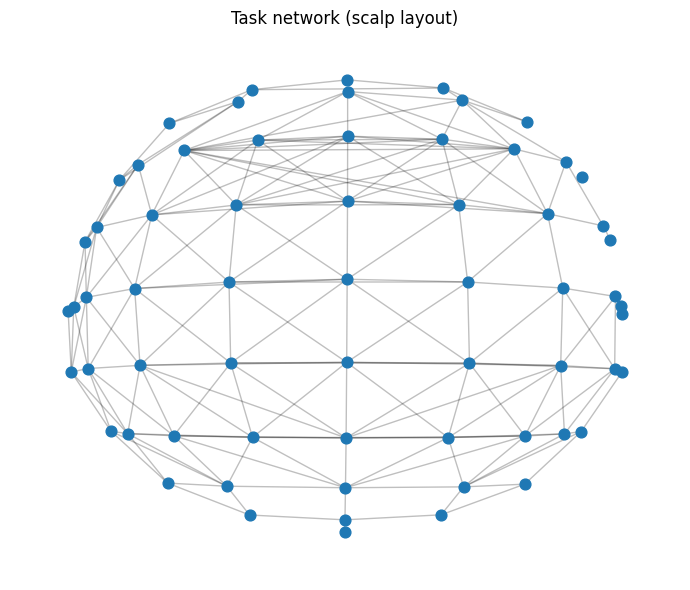

In [40]:
def scalp_positions(raw):
    pos = raw.info.get("chs", [])
    xy = {}
    for ch in raw.info["chs"]:
        name = ch["ch_name"]
        loc = ch["loc"][:3]  # x,y,z in head coords
        xy[name] = (loc[0], loc[1])  # top-down projection
    return xy

pos2d = scalp_positions(raw_rest_alpha)

def draw_graph_scalp(G, title, outfile, pos2d):
    plt.figure(figsize=(7, 6))
    # Only keep positions for nodes that exist in the graph
    pos = {n: pos2d[n] for n in G.nodes if n in pos2d}
    nx.draw_networkx_nodes(G, pos, node_size=60)
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.show()

draw_graph_scalp(G_rest, "Rest network (scalp layout)", "figures/graph_rest_scalp.png", pos2d)
draw_graph_scalp(G_task, "Task network (scalp layout)", "figures/graph_task_scalp.png", pos2d)
